# 사전작업

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset')

In [ ]:
df = pd.read_csv('rawdata.csv')
df_arima = df[['날짜', '청담대교_유량', '청담대교_수위', '잠수교_유량', '잠수교_수위', '한강대교_유량', '한강대교_수위', '행주대교_유량', '행주대교_수위']]

In [ ]:
# 한강대교_유량 : 결측치 1279개 
nanIndex2 = df_arima[df_arima['한강대교_유량'].isnull()].index

# 연속적인 결측치와 불연속적인 결측치 구분
unconsecutive = []
consecutive = []
i = 0
while i < len(nanIndex2):
    if nanIndex2[i]+1 in nanIndex2:
        consecutive.extend([nanIndex2[i], nanIndex2[i+1]])
        try:
            i += 2
        except: #i가 len(nanIndex2) - 1
            break
    elif nanIndex2[i]-1 in nanIndex2: #반복 구간의 마지막 인덱스일 경우
        consecutive.append(nanIndex2[i])
        i += 1
    else:
        unconsecutive.append(nanIndex2[i])
        i += 1

# consecutive unconsecutive 합쳐서 1279인지 확인 
len(consecutive + unconsecutive)

1279

In [ ]:
# consecutive 내에서 구간별로 분리
dummy = []
consecutive2 = [] # 2차원 consecutive
for i in consecutive: 
    dummy.append(i)
    if i+1 not in consecutive:
        if i == consecutive[-2]: #만약 마지막 반복일 경우, consecutive[-1]을 추가로 넣어주어야 함
            dummy.append(i+1)
            consecutive2.append(dummy)
        else: 
            consecutive2.append(dummy)
            dummy= []             

In [ ]:
# 2차원 consecutive의 모양 확인(길이, 첫index, 끝index)
for i in range(len(consecutive2)):
    print(len(consecutive2[i]), consecutive2[i][0], consecutive2[i][-1])

21 91352 91372
167 91377 91543
49 95108 95156
129 95988 96116
22 97716 97737
15 102598 102612
101 110259 110359
117 119757 119873
156 119898 120053
58 140613 140670
116 180951 181066
102 243029 243130
26 247281 247306
199 261936 262134


In [ ]:
# unconsecutive 보간처리 - 하나이므로 그냥 손수 보간에 필요한 인덱스 만듦
unconsecutive2 = [236079, 236080, 236081]

# unconsecutive 보간처리 - 바로 df_arima에 합치기
df_arima.loc[unconsecutive2, ['한강대교_유량']] = df_arima.loc[unconsecutive2, ['한강대교_유량']].interpolate(axis = 0)
df_arima.loc[unconsecutive2, ['한강대교_유량']]
# loc을 사용했더니 Inplace를 True로 해주어도 값이 업데이트 되지 않았음

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,한강대교_유량
236079,473.290
236080,489.265
236081,505.240


# 원래 그래프 (432일 전후 출력)
##### '우클릭 > 새 탭에서 이미지 열기' 하면 비교 편함

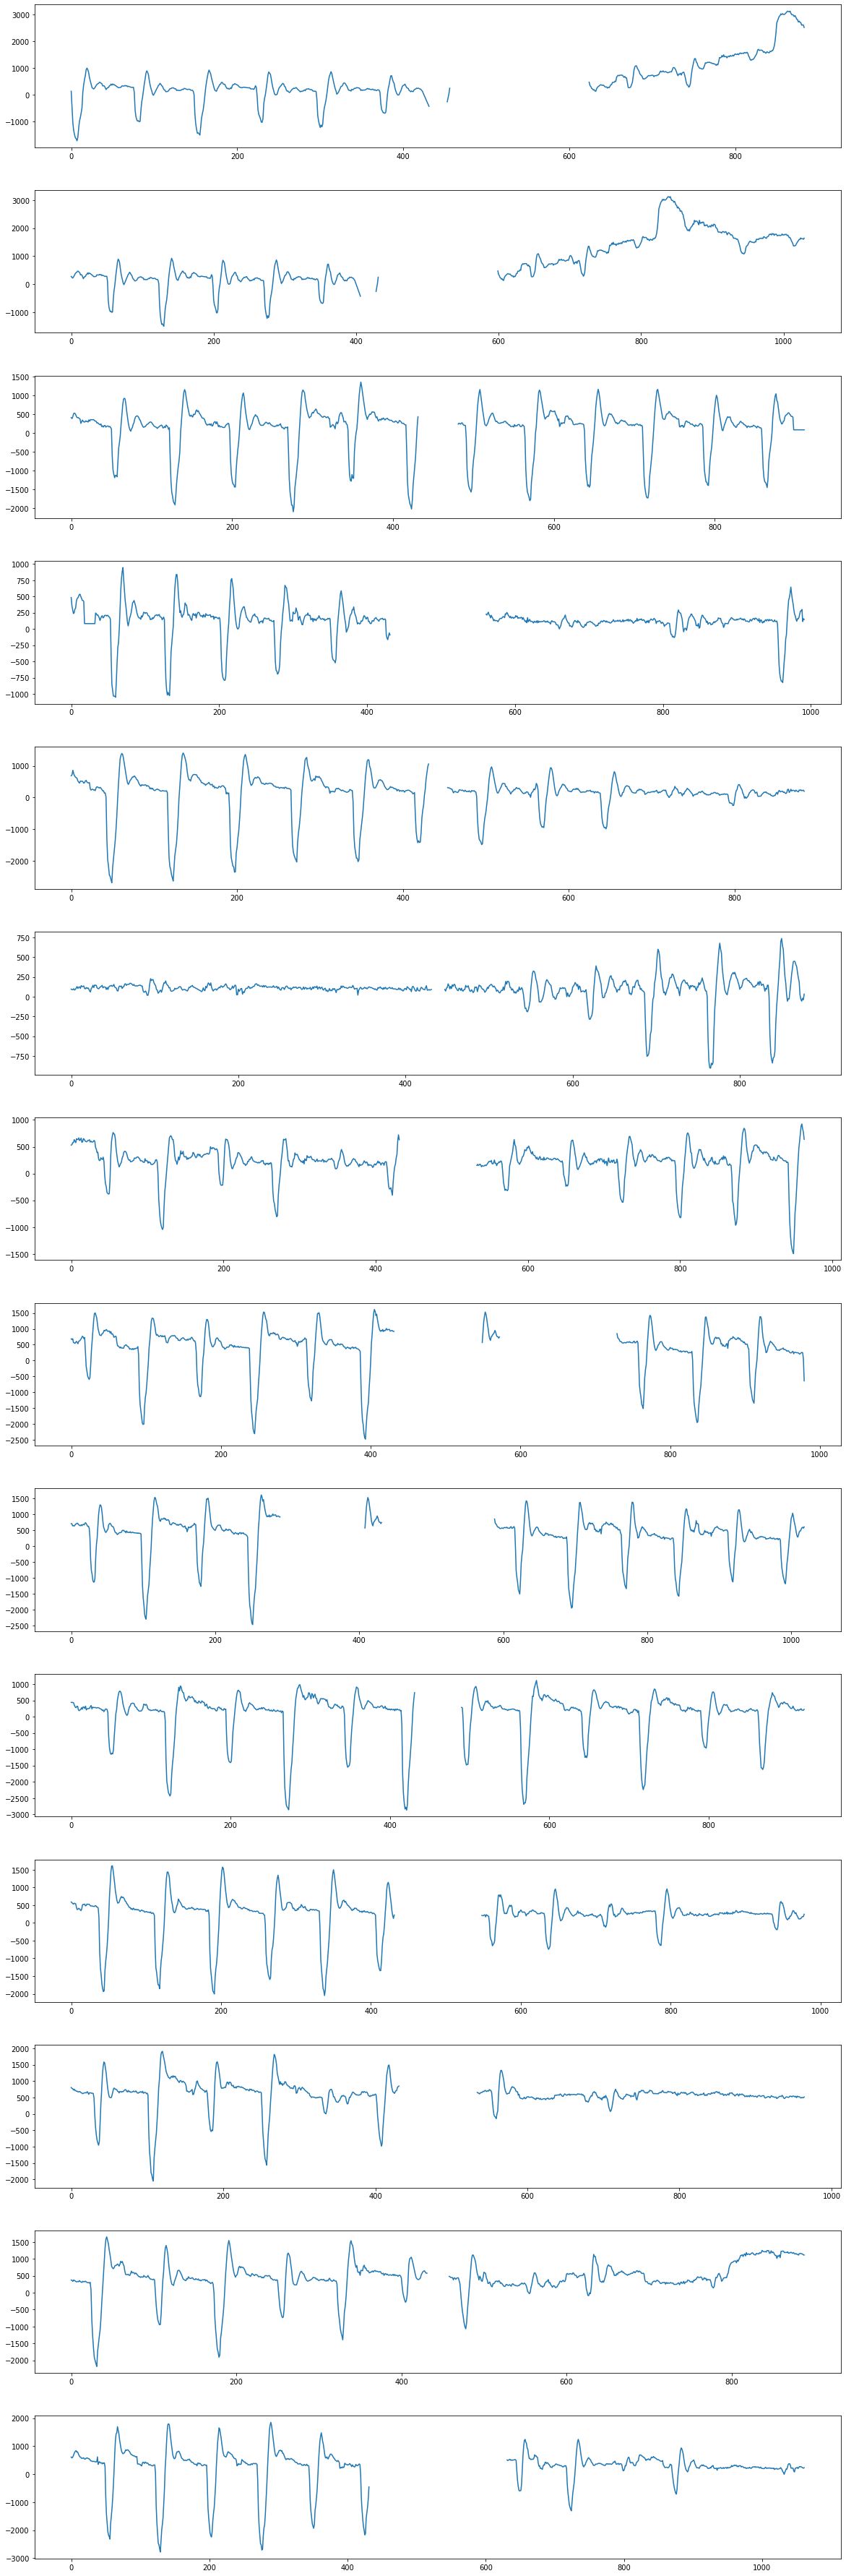

In [ ]:
# consecutive arima - 분포 그려보기


# 80


In [ ]:
df = pd.read_csv('rawdata.csv')

df_arima = df[['날짜', '청담대교_유량', '청담대교_수위', '잠수교_유량', '잠수교_수위', '한강대교_유량', '한강대교_수위', '행주대교_유량', '행주대교_수위']]

# unconsecutive 보간처리 - 바로 df_arima에 합치기
df_arima.loc[unconsecutive2, ['한강대교_유량']] = df_arima.loc[unconsecutive2, ['한강대교_유량']].interpolate(axis = 0)

In [ ]:
from tqdm import tqdm

n = 80
for tmp in tqdm(consecutive2):
    start = tmp[0]
    model = pm.auto_arima(df_arima['한강대교_유량'][start-n:start], seasonal = True)
    df_arima.loc[tmp, ['한강대교_유량']] = model.predict(len(tmp))

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
  7%|▋         | 1/14 [00:08<01:50,  8.53s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
 14%|█▍        | 2/14 [00:10<00:57,  4.76s/it]/usr/local/lib/python3.7/dist-pack

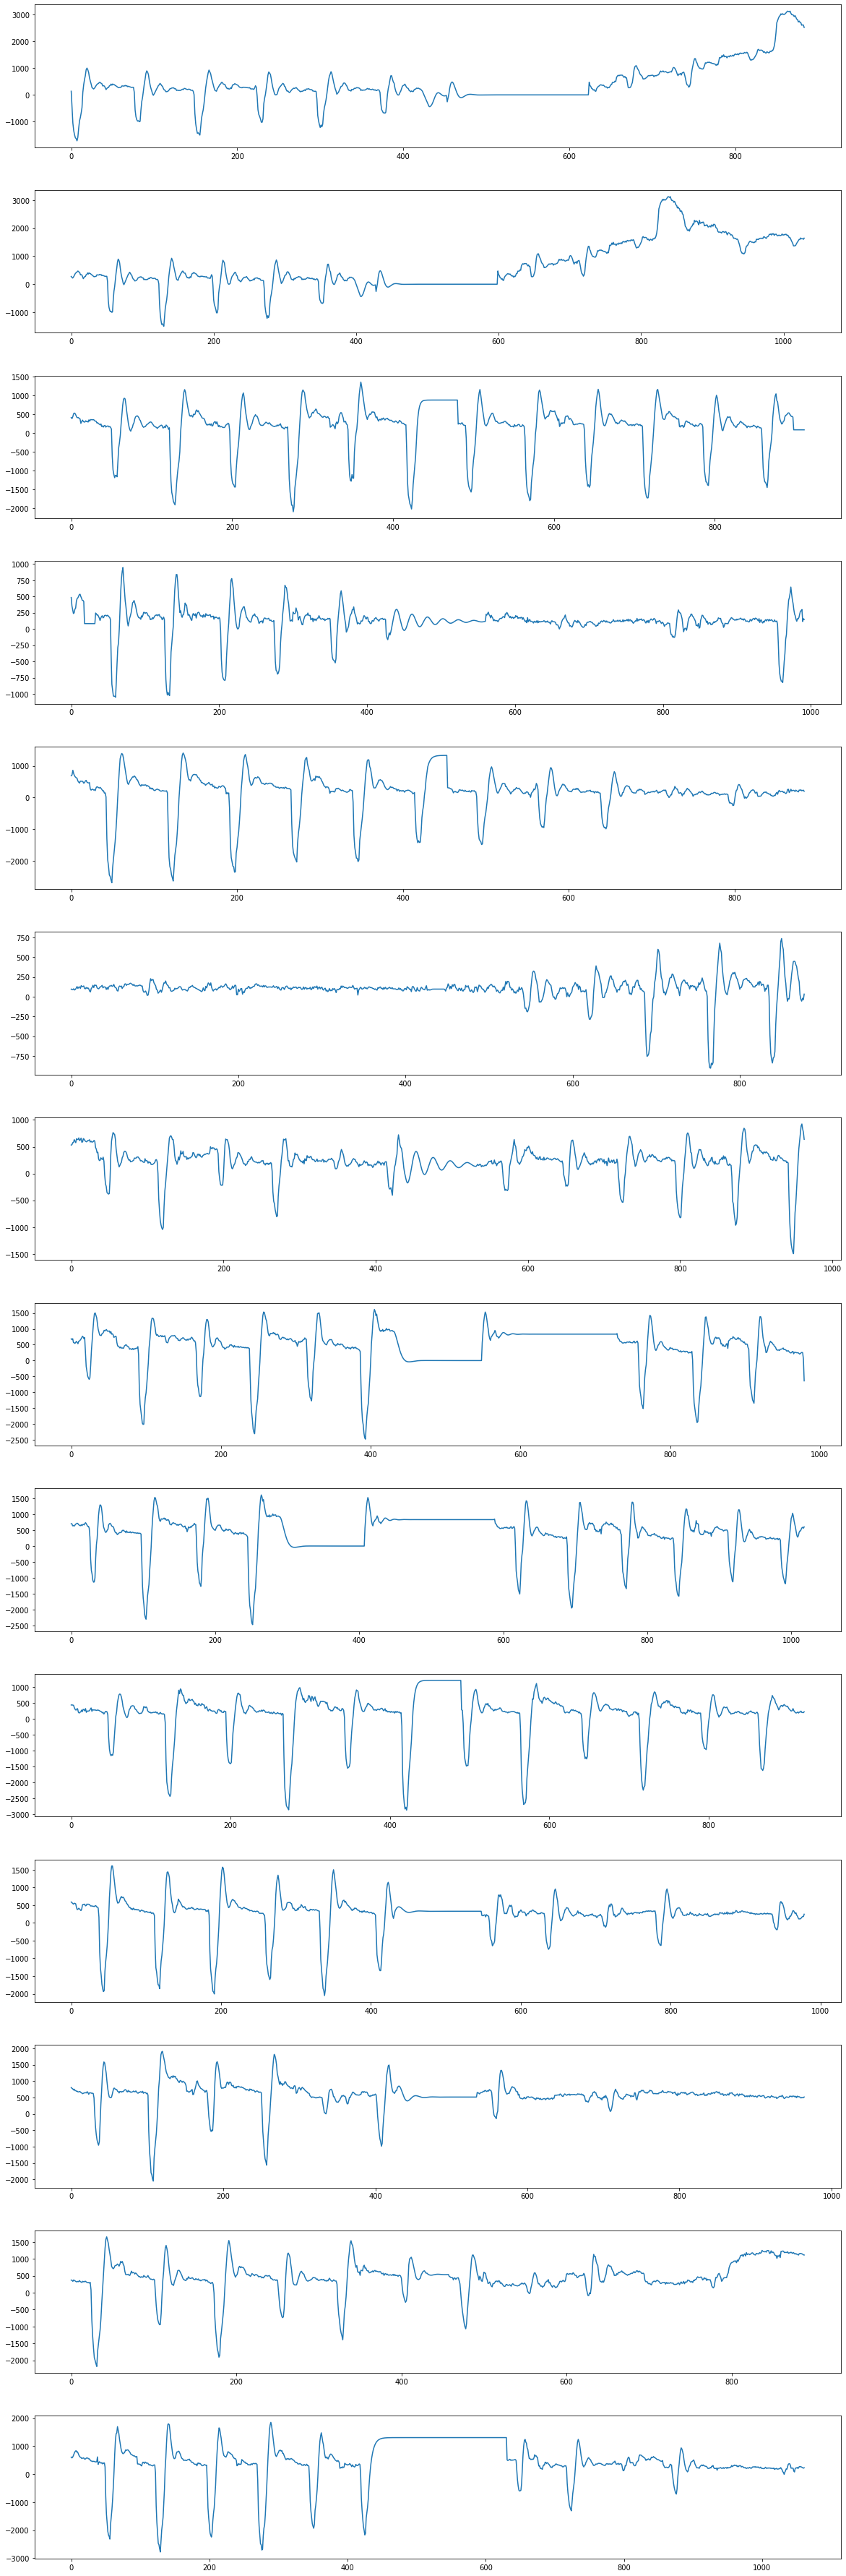

In [ ]:
# consecutive arima - 분포 그려보기(null값 확인)

f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):

    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['한강대교_유량'][start:end]
    axes[i].plot(x, y)

plt.show()

# 100


In [ ]:
df = pd.read_csv('rawdata.csv')

df_arima = df[['날짜', '청담대교_유량', '청담대교_수위', '잠수교_유량', '잠수교_수위', '한강대교_유량', '한강대교_수위', '행주대교_유량', '행주대교_수위']]

# unconsecutive 보간처리 - 바로 df_arima에 합치기
df_arima.loc[unconsecutive2, ['한강대교_유량']] = df_arima.loc[unconsecutive2, ['한강대교_유량']].interpolate(axis = 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
from tqdm import tqdm

n = 100
for tmp in tqdm(consecutive2):
    start = tmp[0]
    model = pm.auto_arima(df_arima['한강대교_유량'][start-n:start], seasonal = True)
    df_arima.loc[tmp, ['한강대교_유량']] = model.predict(len(tmp))

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
  7%|▋         | 1/14 [00:05<01:07,  5.18s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
 14%|█▍        | 2/14 [00:09<00:55,  4.59s/it]/usr/local/lib/python3.7/dist-pack

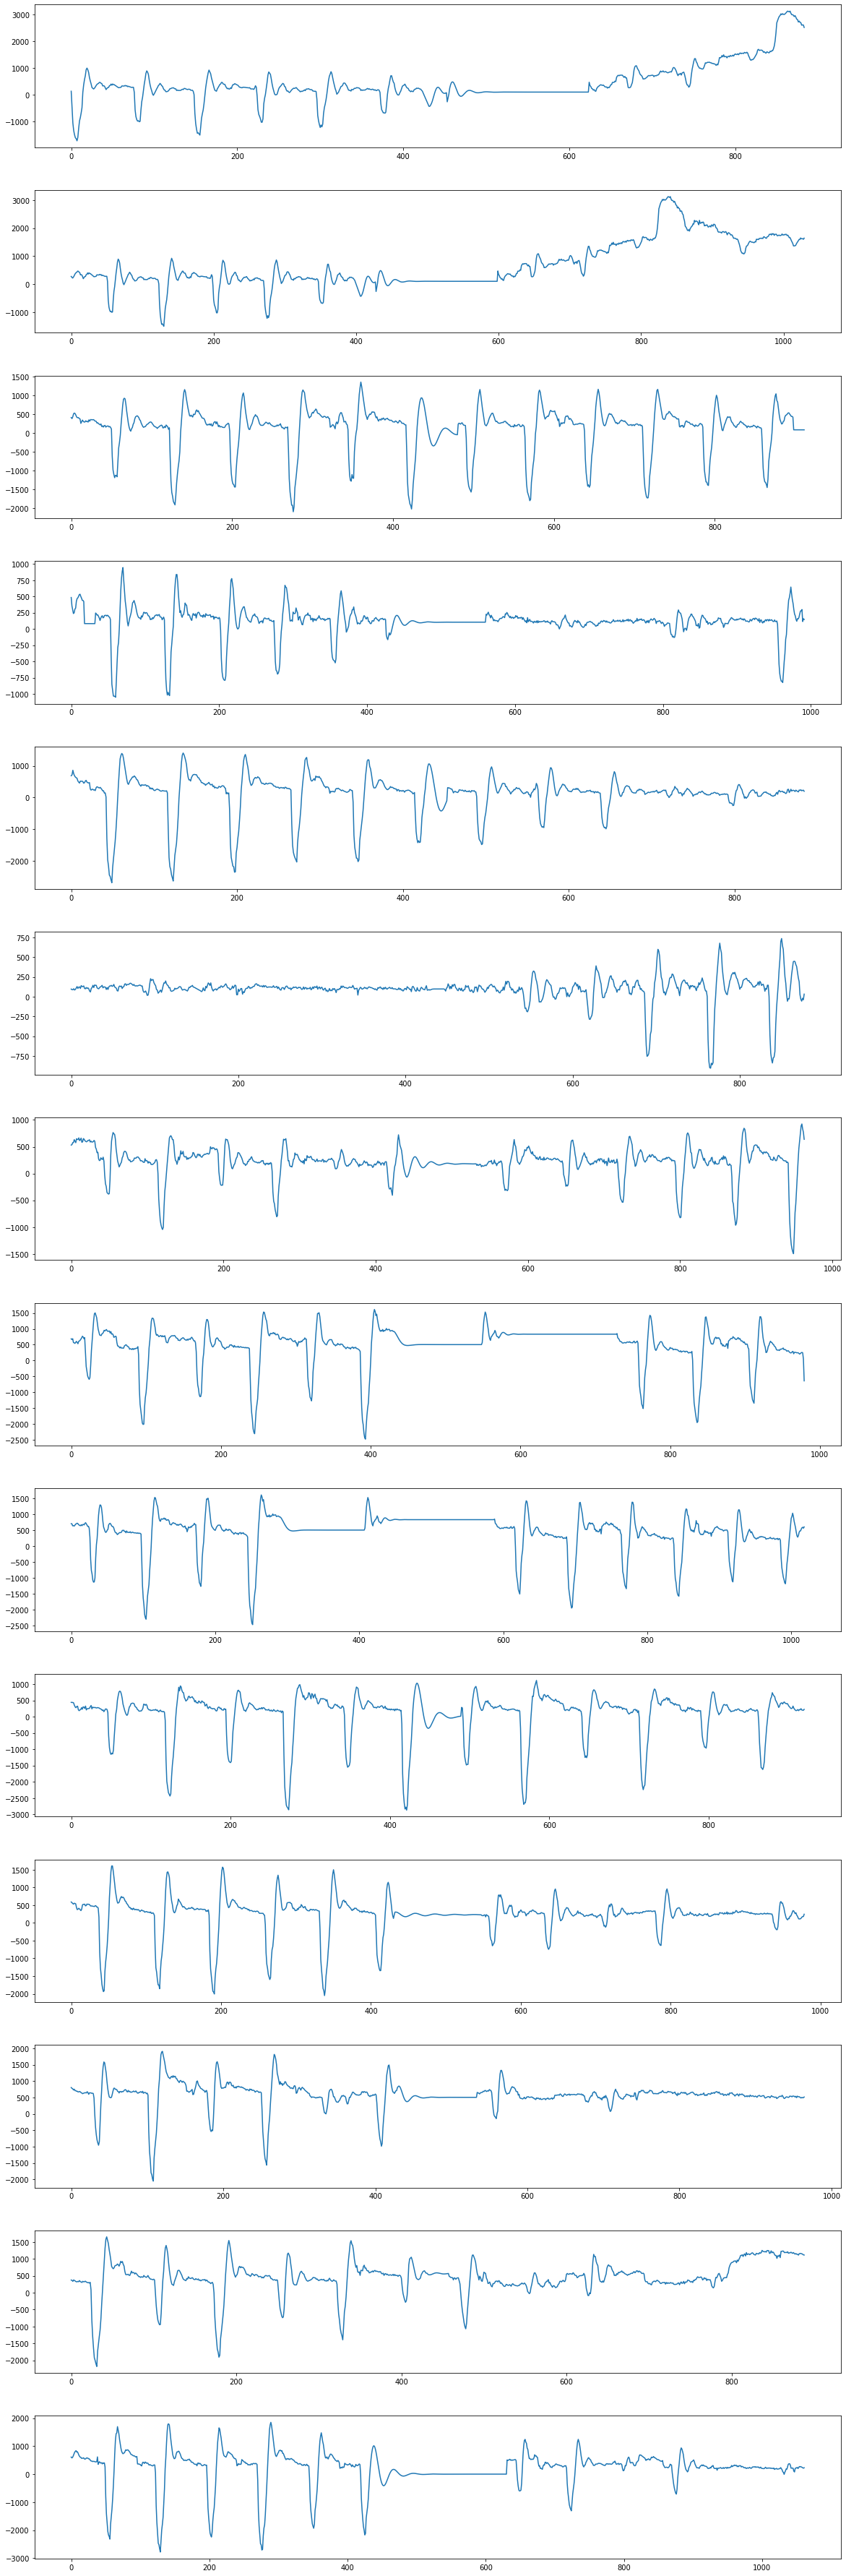

In [ ]:
# consecutive arima - 분포 그려보기(null값 확인)

f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):

    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['한강대교_유량'][start:end]
    axes[i].plot(x, y)

plt.show()


# 300

In [ ]:
df = pd.read_csv('rawdata.csv')

df_arima = df[['날짜', '청담대교_유량', '청담대교_수위', '잠수교_유량', '잠수교_수위', '한강대교_유량', '한강대교_수위', '행주대교_유량', '행주대교_수위']]

# unconsecutive 보간처리 - 바로 df_arima에 합치기
df_arima.loc[unconsecutive2, ['한강대교_유량']] = df_arima.loc[unconsecutive2, ['한강대교_유량']].interpolate(axis = 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
from tqdm import tqdm

n = 300
for tmp in tqdm(consecutive2):
    start = tmp[0]
    model = pm.auto_arima(df_arima['한강대교_유량'][start-n:start], seasonal = True)
    df_arima.loc[tmp, ['한강대교_유량']] = model.predict(len(tmp))

In [ ]:
# consecutive arima - 분포 그려보기(null값 확인)
# 결측치가 잘 처리된건가.. 난 몰라.. 좀 이상한 것 같음..

f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):

    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['한강대교_유량'][start:end]
    axes[i].plot(x, y)

plt.show()

# 432


In [ ]:
df = pd.read_csv('rawdata.csv')

df_arima = df[['날짜', '청담대교_유량', '청담대교_수위', '잠수교_유량', '잠수교_수위', '한강대교_유량', '한강대교_수위', '행주대교_유량', '행주대교_수위']]

# unconsecutive 보간처리 - 바로 df_arima에 합치기
df_arima.loc[unconsecutive2, ['한강대교_유량']] = df_arima.loc[unconsecutive2, ['한강대교_유량']].interpolate(axis = 0)

In [ ]:
from tqdm import tqdm

n = 432
for tmp in tqdm(consecutive2):
    start = tmp[0]
    model = pm.auto_arima(df_arima['한강대교_유량'][start-n:start], seasonal = True)
    df_arima.loc[tmp, ['한강대교_유량']] = model.predict(len(tmp))

In [ ]:
# consecutive arima - 분포 그려보기(null값 확인)

f, axes = plt.subplots(len(consecutive2), 1)
f.set_size_inches((20, 65))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(consecutive2)):

    start = consecutive2[i][0]-432
    end = consecutive2[i][-1]+432
    x = range(len(df_arima['날짜'][start:end]))
    y = df_arima['한강대교_유량'][start:end]
    axes[i].plot(x, y)

plt.show()

# 저장

In [ ]:
# 일단 csv로 만들어...

df_arima[['날짜', '한강대교_유량']].to_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/0819_한강대교_Arima.csv', index = False)

In [ ]:
df_arima['잠수교_수위'].interpolate()
df_arima['청담대교_수위'].interpolate()
df_arima['한강대교_수위'].interpolate()
df_arima['행주대교_수위'].interpolate()
df_arima['한강대교_유량'].interpolate()
df_arima['행주대교_유량'].interpolate()